In [8]:
import os
from aerobot.io import load_results_dict, RESULTS_PATH
import matplotlib.pyplot as plt
from aerobot.plot import plot_configure_mpl
from matplotlib.gridspec import GridSpec
from aerobot.dataset import dataset_load_training_validation
import pandas as pd 
import numpy as np 

%load_ext autoreload
%autoreload 2

plot_configure_mpl(figure_height=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
training_dataset, validation_dataset = dataset_load_training_validation(feature_type='KO', to_numpy=False) # Feature type doesn't matter, as we just want the labels. 
training_labels, validation_labels = training_dataset['labels'], validation_dataset['labels']

In [10]:
training_counts = training_labels['Phylum'].value_counts().to_dict()
validation_counts = validation_labels['Phylum'].value_counts().to_dict()
phyla = list(set(validation_counts.keys()).union(set(training_counts.keys())))

phyla_counts_df = pd.DataFrame()
phyla_counts_df['phylum'] = phyla
phyla_counts_df['training'] = [training_counts.get(phylum, 0) for phylum in phyla]
phyla_counts_df['validation'] = [validation_counts.get(phylum, 0) for phylum in phyla]
phyla_counts_df['total'] = phyla_counts_df['validation'] + phyla_counts_df['training']
phyla_counts_df = phyla_counts_df.sort_values('total', ascending=False)

# Only look at the top 20 most abundant phyla...
phyla_counts_df = phyla_counts_df.iloc[:20]
# phyla_counts_df.head()

In [11]:
training_counts = training_labels['physiology'].value_counts().to_dict()
validation_counts = validation_labels['physiology'].value_counts().to_dict()
labels = ['aerobe', 'anaerobe', 'facultative']

labels_counts_df = pd.DataFrame()
labels_counts_df['labels'] = labels
labels_counts_df['training'] = [training_counts.get(label, 0) for label in labels]
labels_counts_df['training'] = labels_counts_df.training / labels_counts_df.training.sum() # Convert to fractions. 
labels_counts_df['validation'] = [validation_counts.get(label, 0) for label in labels]
labels_counts_df['validation'] = labels_counts_df.validation / labels_counts_df.validation.sum() # Convert to fractions. 

labels_counts_df = labels_counts_df.set_index('labels')

for label in ['aerobe', 'anaerobe', 'facultative']:
    print(f'Number of {label} in training set:', labels_counts_df.loc[label].training.item())
    print(f'Number of {label} in validation set:', labels_counts_df.loc[label].validation.item())
    print()

Number of aerobe in training set: 0.5042553191489362
Number of aerobe in validation set: 0.5106060606060606

Number of anaerobe in training set: 0.3656028368794326
Number of anaerobe in validation set: 0.3575757575757576

Number of facultative in training set: 0.1301418439716312
Number of facultative in validation set: 0.1318181818181818



# SI Figure 1

In [12]:
def plot_si_figure_1a(phyla_counts_df, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot a barplot showing the twenty most common phyla in the training and validation datasets.'''

    ax = fig.add_subplot(grid)
    n_phyla = len(phyla_counts_df)

    kwargs = {'edgecolor':'k', 'lw':0.5}
    ax.bar(np.arange(n_phyla), phyla_counts_df.training.values, **kwargs)
    ax.bar(np.arange(n_phyla), phyla_counts_df.validation.values, bottom=phyla_counts_df.training.values, **kwargs)

    ax.set_xticks(np.arange(n_phyla), labels=phyla_counts_df.phylum, rotation=90)
    ax.legend(['training data', 'validation data'])
    ax.set_ylabel('number of genomes')

    ax.set_title('Phylogenetic coverage')

    return ax


In [13]:
def plot_si_figure_1b(labels_counts_df, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot a stacked barplot showing the makeup of the training and validation datasets, i.e. how many instances
    of each metabolic category are present in each dataset.'''

    ax = fig.add_subplot(grid)
    ax.set_title('Dataset composition')

    kwargs = {'edgecolor':'k', 'lw':0.5}
    ax.bar(np.arange(2), labels_counts_df.iloc[0].values, **kwargs)
    ax.bar(np.arange(2), labels_counts_df.iloc[1].values, bottom=labels_counts_df.iloc[0].values, **kwargs)
    ax.bar(np.arange(2), labels_counts_df.iloc[2].values, bottom=labels_counts_df.iloc[0:2].values.sum(axis=0), **kwargs)

    ax.set_xticks(np.arange(2), labels=['training', 'validation'])
    ax.legend(['aerobe', 'anaerobe', 'facultative'])
    ax.set_ylabel('proportion')

    return ax


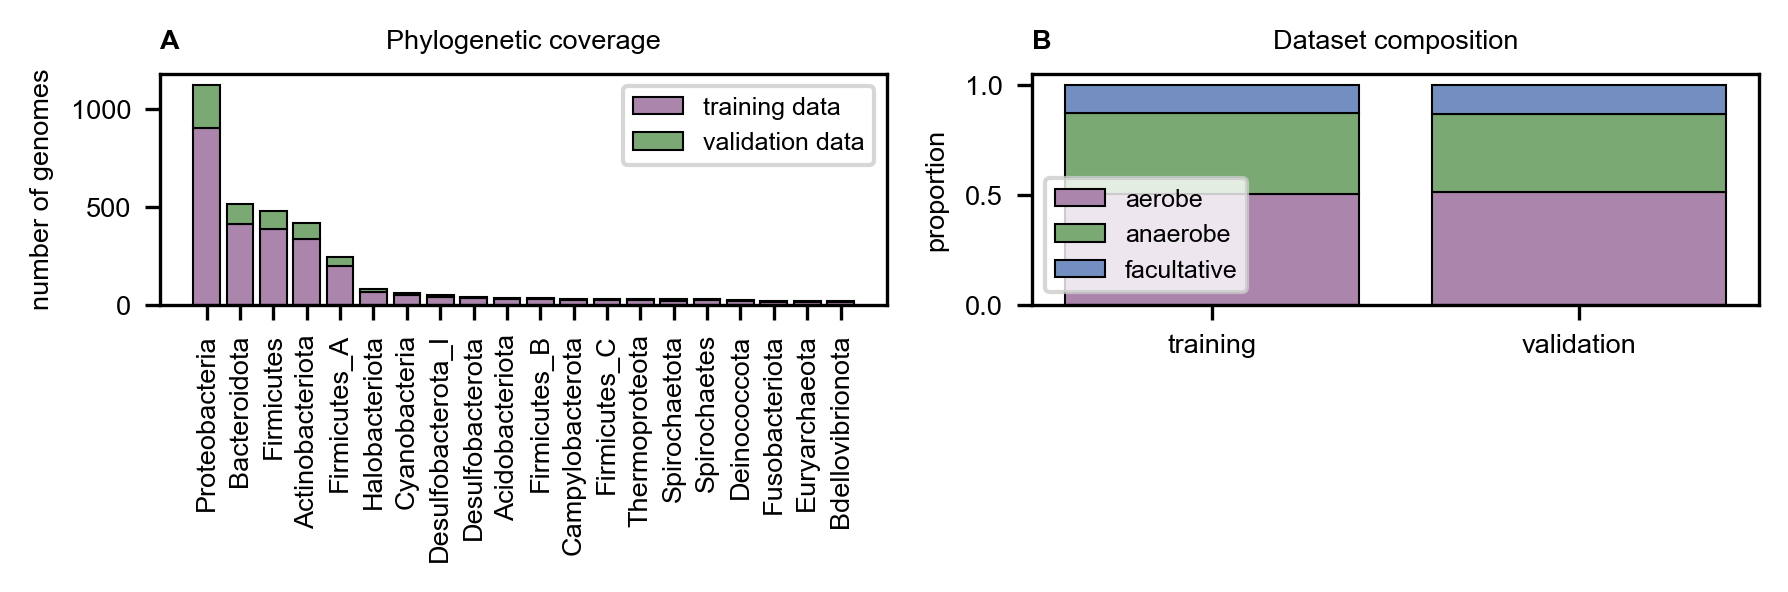

In [14]:
fig = plt.figure()
grid = GridSpec(1, 2, wspace=0.2) 

axes = []
axes.append(plot_si_figure_1a(phyla_counts_df, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_1b(labels_counts_df, grid=grid[0, 1], fig=fig))

for ax, ax_label in zip(axes, 'AB'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/si_fig1.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()
